In [6]:
# Part 0: Setup and Configuration


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier  # <-- Import for MLP
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for saving results
results_path = '/content/drive/My Drive/results/'
model_path = os.path.join(results_path, 'models/')
vis_path = os.path.join(results_path, 'mlp_visualizations/') # <-- Changed folder name

# Create directories if they don't exist
os.makedirs(model_path, exist_ok=True)
os.makedirs(vis_path, exist_ok=True)

print("Setup complete. Libraries imported and paths defined.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete. Libraries imported and paths defined.


In [7]:
# Part 1: Data Loading and Preparation


# Define the path to your preprocessed data
final_path = os.path.join(results_path, "final_preprocessed_dataset.csv")

try:
    # Load the dataset
    df = pd.read_csv(final_path)
    print("Loaded final preprocessed dataset:", df.shape)
    print("Columns:", df.columns.tolist())

    # Separate features (X) and target (y)
    X = df.drop(columns=["Target"])
    y = df["Target"]

    # Split the data into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

except FileNotFoundError:
    print(f" Error: The file '{final_path}' was not found.")
    print("Please run the preprocessing script first to generate this file.")
    exit()

Loaded final preprocessed dataset: (6295, 11)
Columns: ['PC1_Approval_rate_Total_units_approved_Total_units_grade', 'PC2_Total_units_enrolled_Total_units_approved_Total_units_grade', 'PC3_Total_units_enrolled_Total_units_grade_Curricular units 1st sem (enrolled)', 'PC4_Application mode_Age at enrollment_Displaced', 'PC5_Debtor_Tuition fees up to date_Age at enrollment', 'PC6_Debtor_Curricular units 1st sem (evaluations)_Curricular units 2nd sem (evaluations)', 'PC7_Gender_Displaced_Age at enrollment', 'PC8_Scholarship holder_Curricular units 1st sem (evaluations)_Curricular units 2nd sem (evaluations)', 'PC9_Displaced_Application mode_Age at enrollment', 'PC10_Tuition fees up to date_Debtor_Displaced', 'Target']

Training set shape: (5036, 10)
Testing set shape: (1259, 10)


In [8]:
# Part 2: Model and Hyperparameter Definition


# Initialize the MLP model
# random_state for reproducibility
# max_iter is set high to give the model time to converge
# early_stopping=True stops training if performance on a validation set doesn't improve
mlp_model = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, n_iter_no_change=10, verbose=False)

# Define the grid of hyperparameters to search
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)], # Architecture: (neurons in layer1, layer2, ...)
    'activation': ['relu', 'tanh'],                      # Activation function for neurons
    'solver': ['adam'],                                  # Optimizer ('adam' is a robust default)
    'alpha': [0.0001, 0.001, 0.01],                     # L2 regularization term (penalty)
    'learning_rate_init': [0.001, 0.01]                  # Initial learning rate
}

print(" MLP model and hyperparameter grid defined.")

 MLP model and hyperparameter grid defined.


In [9]:
# Part 3: Model Training and Hyperparameter Tuning


# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nStarting Grid Search for best MLP hyperparameters...")
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model found
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("\n Best Parameters Found:", best_params)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")


Starting Grid Search for best MLP hyperparameters...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Best Parameters Found: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
Best Cross-Validation Score: 0.7599


In [10]:
# Part 4: Model Evaluation on Test Set


# Make predictions on the unseen test data
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Calculate the accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Print the detailed classification report
print("\nClassification Report:")
class_names = ['Dropout', 'Enrolled', 'Graduate']
print(classification_report(y_test, y_pred, target_names=class_names))


Test Accuracy: 0.7681

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.76      0.79       411
    Enrolled       0.72      0.70      0.71       431
    Graduate       0.77      0.85      0.81       417

    accuracy                           0.77      1259
   macro avg       0.77      0.77      0.77      1259
weighted avg       0.77      0.77      0.77      1259



📸 Confusion matrix saved to /content/drive/My Drive/results/mlp_visualizations/mlp_confusion_matrix.png


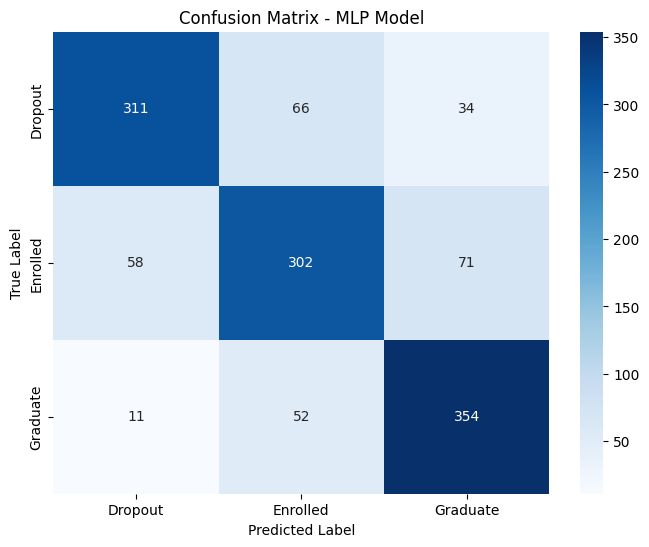

ROC curve saved to /content/drive/My Drive/results/mlp_visualizations/mlp_roc_curve.png


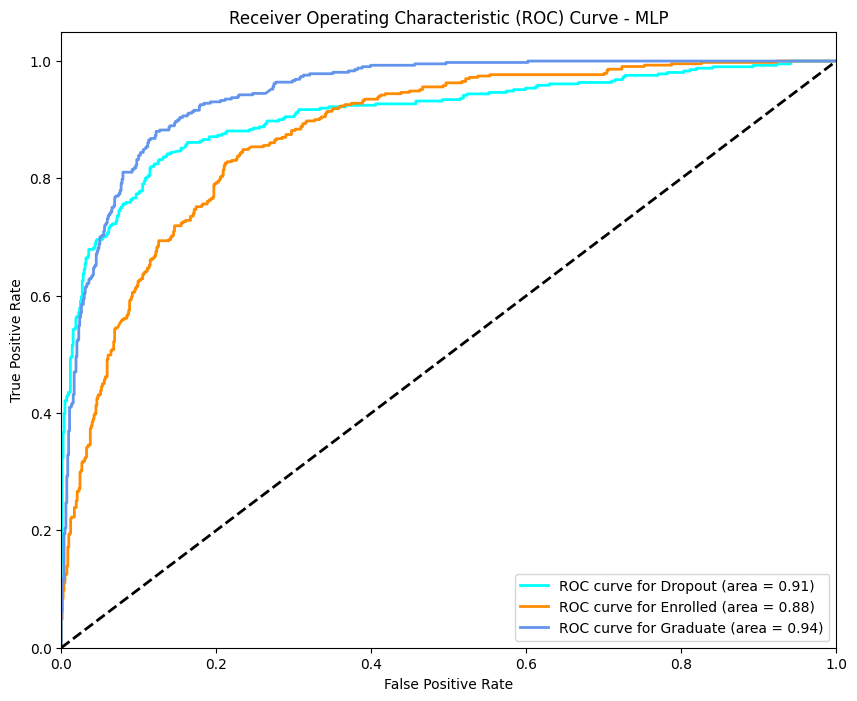

In [11]:
# Part 5: Performance Visualization


# 5a: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - MLP Model') # <-- Updated title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
conf_matrix_path = os.path.join(vis_path, 'mlp_confusion_matrix.png') # <-- Updated path
plt.savefig(conf_matrix_path, bbox_inches='tight')
print(f"📸 Confusion matrix saved to {conf_matrix_path}")
plt.show()

# 5b: ROC Curve for Multi-Class Classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test) # Use predict_proba for MLP

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP')
plt.legend(loc="lower right")
roc_curve_path = os.path.join(vis_path, 'mlp_roc_curve.png')
plt.savefig(roc_curve_path, bbox_inches='tight')
print(f"ROC curve saved to {roc_curve_path}")
plt.show()

In [13]:
 #Part 6: Feature Importance Analysis


print("\nℹFeature Importance for MLP models is not directly interpretable like linear models.")
print("The model learns complex, non-linear relationships between features and the target.")
print("Advanced techniques like SHAP or Permutation Importance would be required to analyze feature impact.")


ℹFeature Importance for MLP models is not directly interpretable like linear models.
The model learns complex, non-linear relationships between features and the target.
Advanced techniques like SHAP or Permutation Importance would be required to analyze feature impact.


In [14]:
# Part 7: Final Cross-Validation


print("\nPerforming final 5-fold cross-validation on the entire dataset...")
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Performing final 5-fold cross-validation on the entire dataset...
5-Fold Cross-Validation Accuracy: 0.7509 ± 0.0333


In [15]:
# Part 8: Saving Results and Model


# Save the best model to a file
model_file = os.path.join(model_path, 'mlp_dropout_model.pkl')
joblib.dump(best_model, model_file)
print(f"\n Best MLP model saved to {model_file}")

# Save the results summary to a CSV file
results_summary = {
    "Best Parameters": [str(best_params)],
    "Best CV Score (GridSearch)": [grid_search.best_score_],
    "Test Accuracy": [accuracy],
    "Final CV Mean Accuracy": [cv_scores.mean()],
    "Final CV Std Dev": [cv_scores.std()]
}
results_df = pd.DataFrame(results_summary)
results_file = os.path.join(results_path, 'mlp_results_summary.csv')
results_df.to_csv(results_file, index=False)
print(f"Results summary saved to {results_file}")

print("\n MLP model training and evaluation completed successfully!")


 Best MLP model saved to /content/drive/My Drive/results/models/mlp_dropout_model.pkl
Results summary saved to /content/drive/My Drive/results/mlp_results_summary.csv

 MLP model training and evaluation completed successfully!
